# 2- Word  vectors visualization

Here, we will try to show the regularities visually.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.read_table("../data/got_word_vectors.txt", delimiter=" ", header=None, index_col=0)
df = df.div(np.linalg.norm(df, axis=1), axis=0)

In [2]:
characters = pd.read_csv("../data/got_characters.csv")
characters.index = characters["first_name"]
characters.head()

,full_name,first_name,last_name
first_name,,,
aegon,Aegon Targaryen,aegon,targaryen
aemon,Aemon Targaryen,aemon,targaryen
aerys,Aerys Targaryen,aerys,targaryen
alerie,Alerie Tyrell,alerie,tyrell
arya,Arya Stark,arya,stark


## 2-D T-SNE projection of the main characters

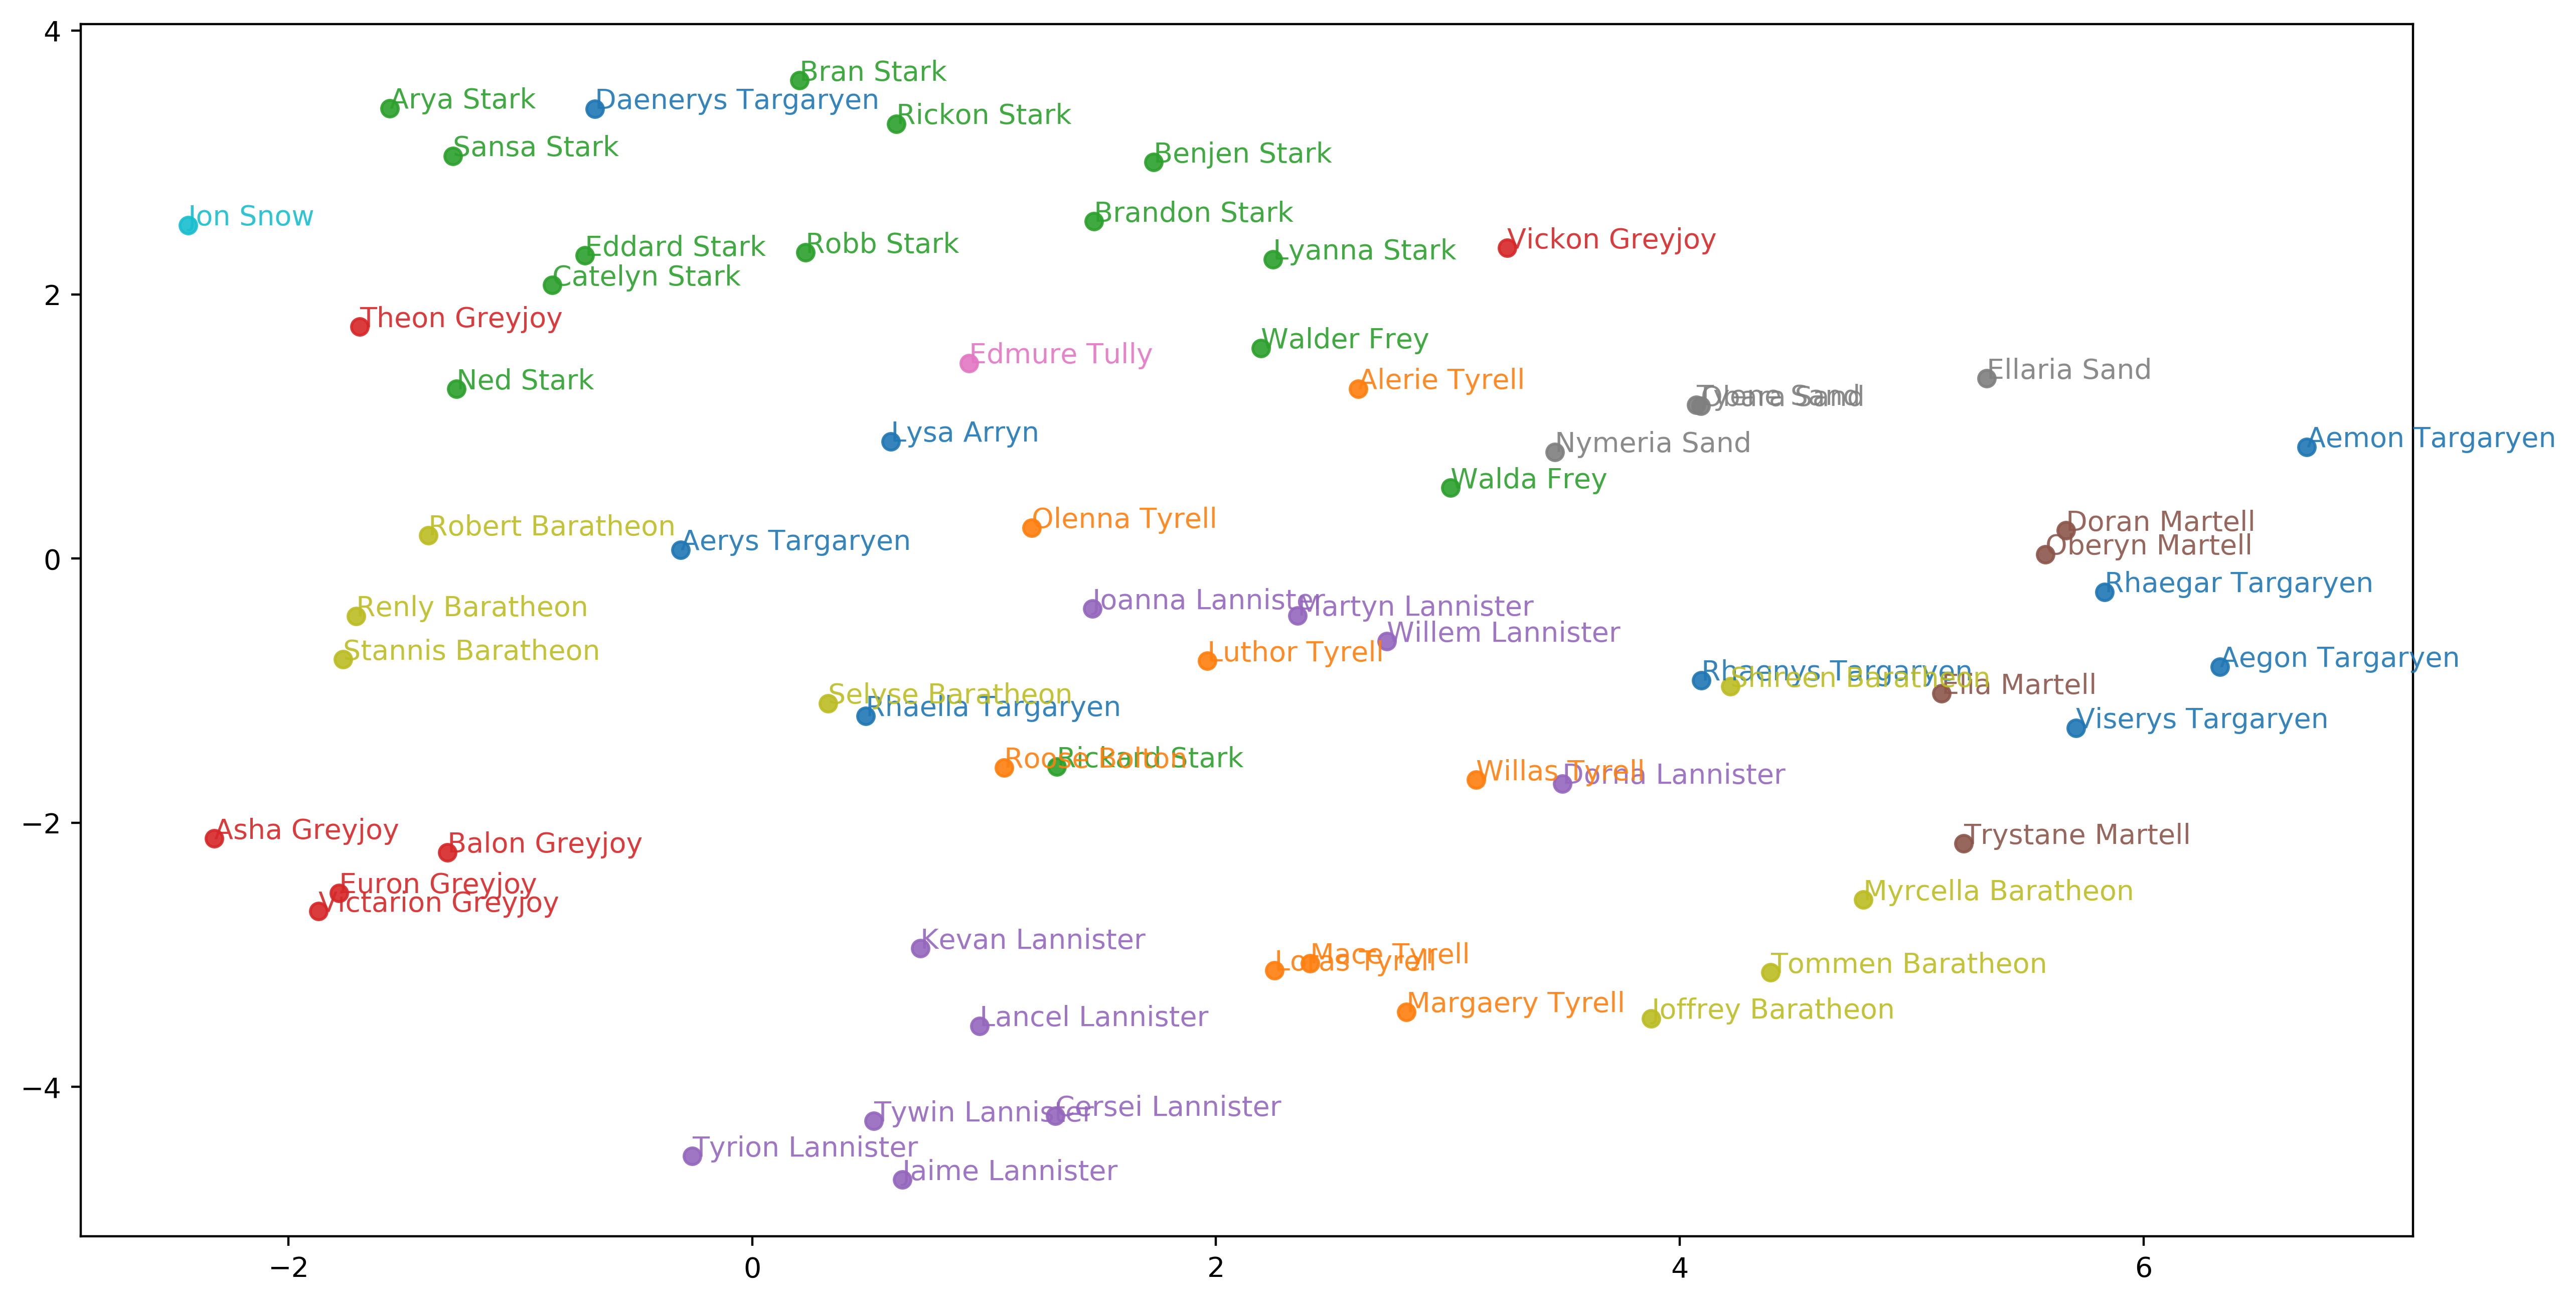

In [3]:
dfc = df.loc[characters["first_name"]].copy()
house_colors = {h:plt.cm.tab10.colors[i%10] for i,h in enumerate(characters["last_name"].unique())}

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(dfc)
dfc['x-tsne'] = tsne_results[:,0]
dfc['y-tsne'] = tsne_results[:,1]

fig = plt.figure(figsize=(15,8), dpi=400)
ax = fig.add_subplot(1,1,1)

dfc = pd.concat([dfc, characters], axis=1)
for i in range(len(dfc)):
    ax.scatter(
        x=dfc.iloc[i]["x-tsne"], 
        y=dfc.iloc[i]["y-tsne"],
        alpha=0.9,
        c=house_colors[dfc.iloc[i]["last_name"]]
    )
    ax.text(
        x=dfc.iloc[i]["x-tsne"],
        y=dfc.iloc[i]["y-tsne"],
        s=dfc.iloc[i]["full_name"],
        alpha=0.9,
        color=house_colors[dfc.iloc[i]["last_name"]]
    )
plt.show()

## Word pairs and regularities

In [4]:
def plot_word_pairs(df, word_pairs, method="PCA"):
    """Plot a 2D projection of selected words and add 'relation' vectors between pairs"""
    words = list(set([w for pair in word_pairs for w in pair]))
    dfs = df.loc[words].copy()
    
    if method=="PCA":
        d = PCA(n_components=2)
    elif method=="TSNE":
        d = TSNE(n_components=2)
        
    results = d.fit_transform(dfs.iloc[:,:100])
    dfs['x'] = results[:,0]
    dfs['y'] = results[:,1]

    fig = plt.figure(figsize=(17,5), dpi=300)
    ax = fig.add_subplot(1,1,1)
    colors = plt.cm.tab10.colors
    for i in range(len(dfs)):
        ax.scatter(
            x=dfs.iloc[i]["x"],
            y=dfs.iloc[i]["y"],
            alpha=0.9,
            c=colors[i%10]
        )
        ax.text(
            x=dfs.iloc[i]["x"],
            y=dfs.iloc[i]["y"],
            s=words[i],
            color=colors[i%10]
        )

    for pair in word_pairs: 
        w1, w2 = pair
        w1x, w1y = dfs.loc[w1]["x"], dfs.loc[w1]["y"]
        w2x, w2y = dfs.loc[w2]["x"], dfs.loc[w2]["y"]
        vec = np.array([[w1x, w1y, w2x-w1x, w2y-w1y]])
        X, Y, U, V = zip(*vec)
        ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, width=0.002, color=colors[0])    
    plt.show()

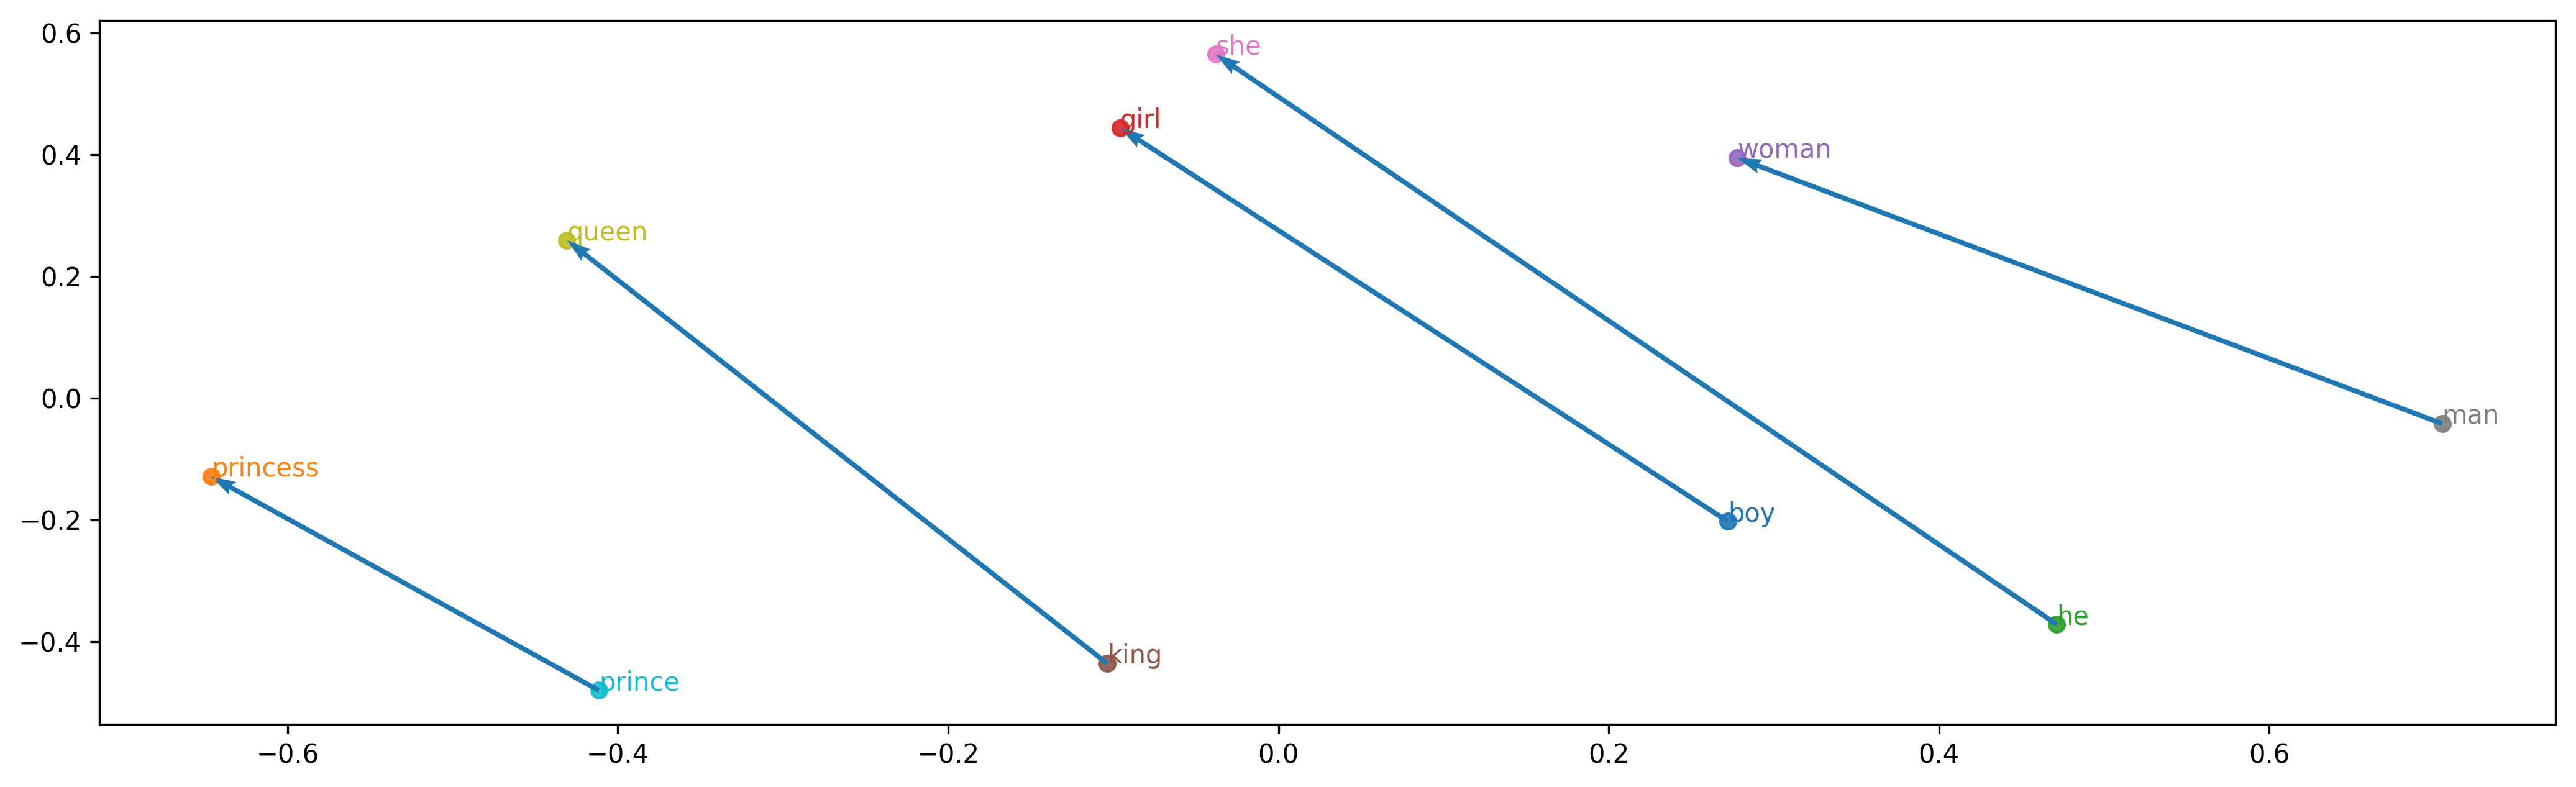

In [5]:
# gender
word_pairs = [
    ("man", "woman"), 
    ("boy", "girl"),
    ("king", "queen"),
    ("prince", "princess"),
    ("he", "she"),
]
plot_word_pairs(df, word_pairs, method="PCA")

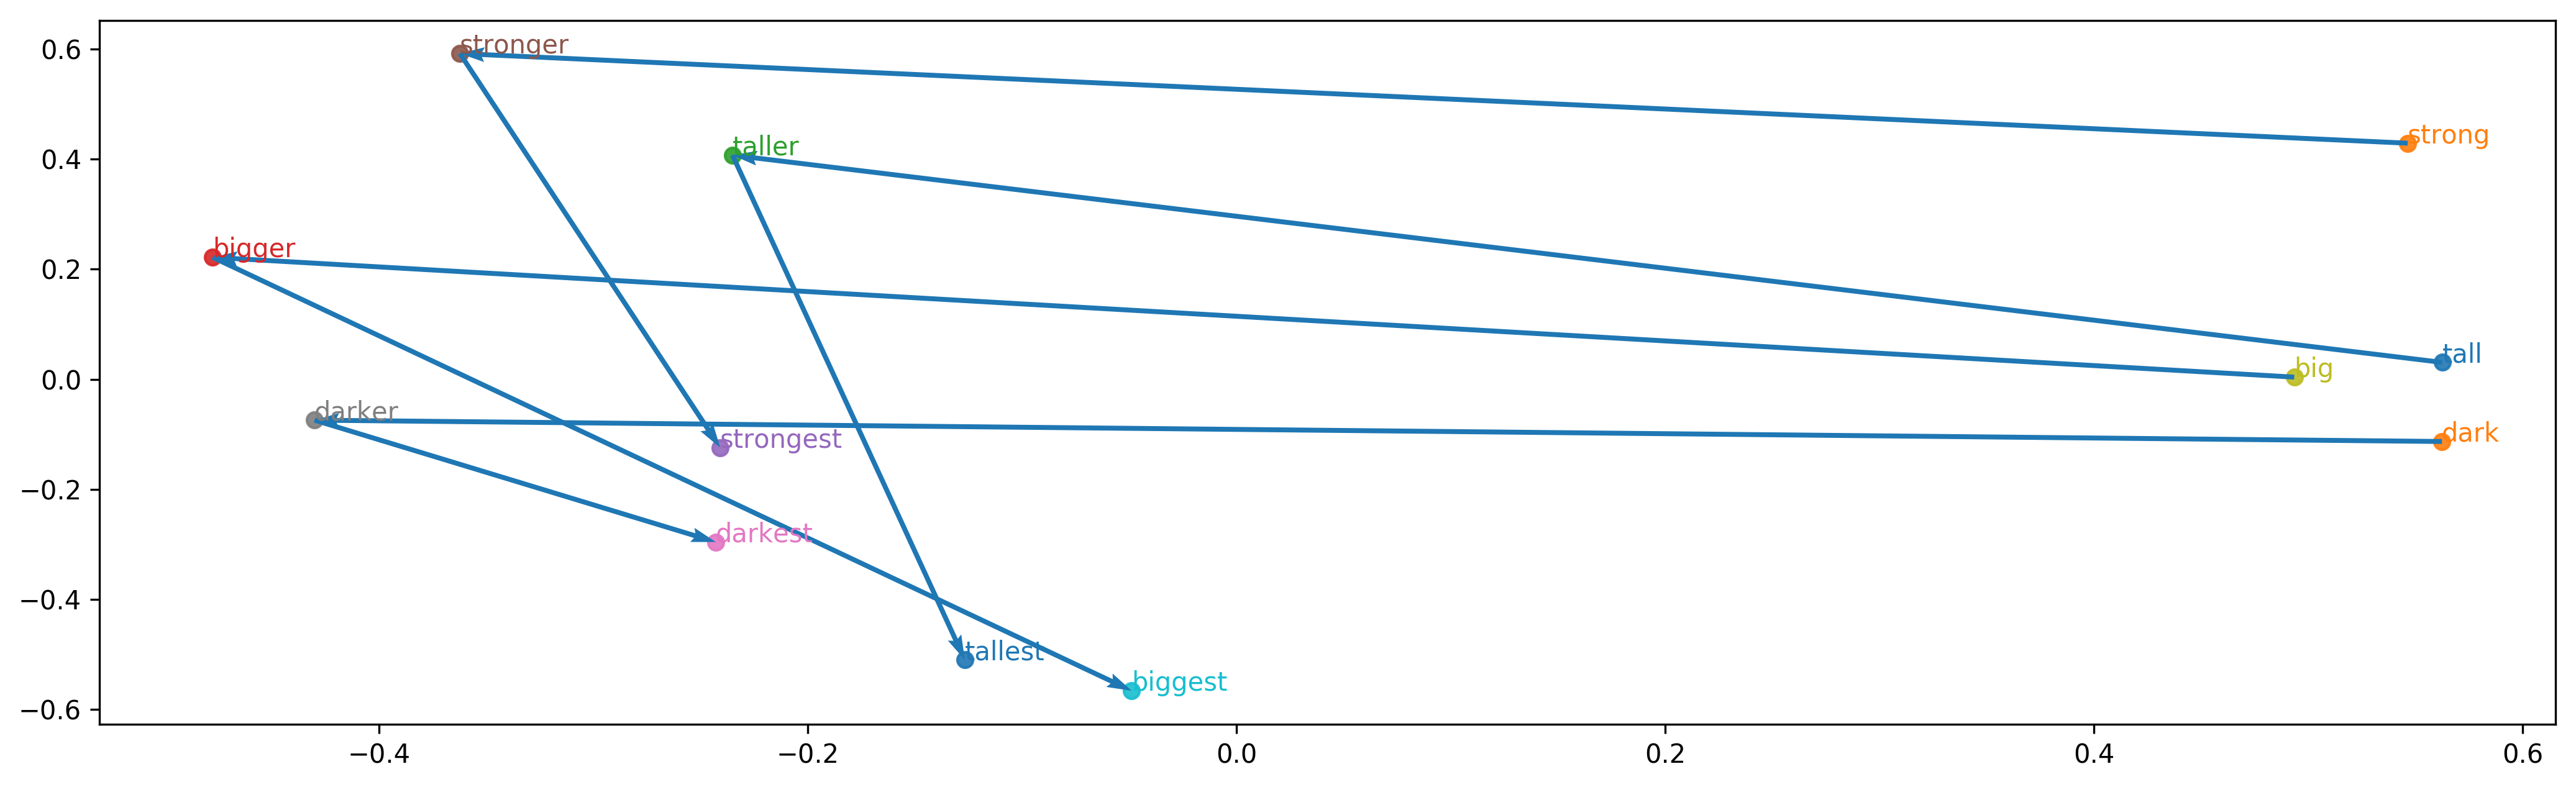

In [6]:
# adjectives, comparatives, superlatives
word_pairs = [
    ("strong", "stronger"),
    ("stronger", "strongest"),
    ("dark", "darker"),
    ("darker", "darkest"),
    ("big", "bigger"),
    ("bigger", "biggest"),
    ("tall", "taller"),
    ("taller", "tallest"),
]
plot_word_pairs(df, word_pairs, method="PCA")

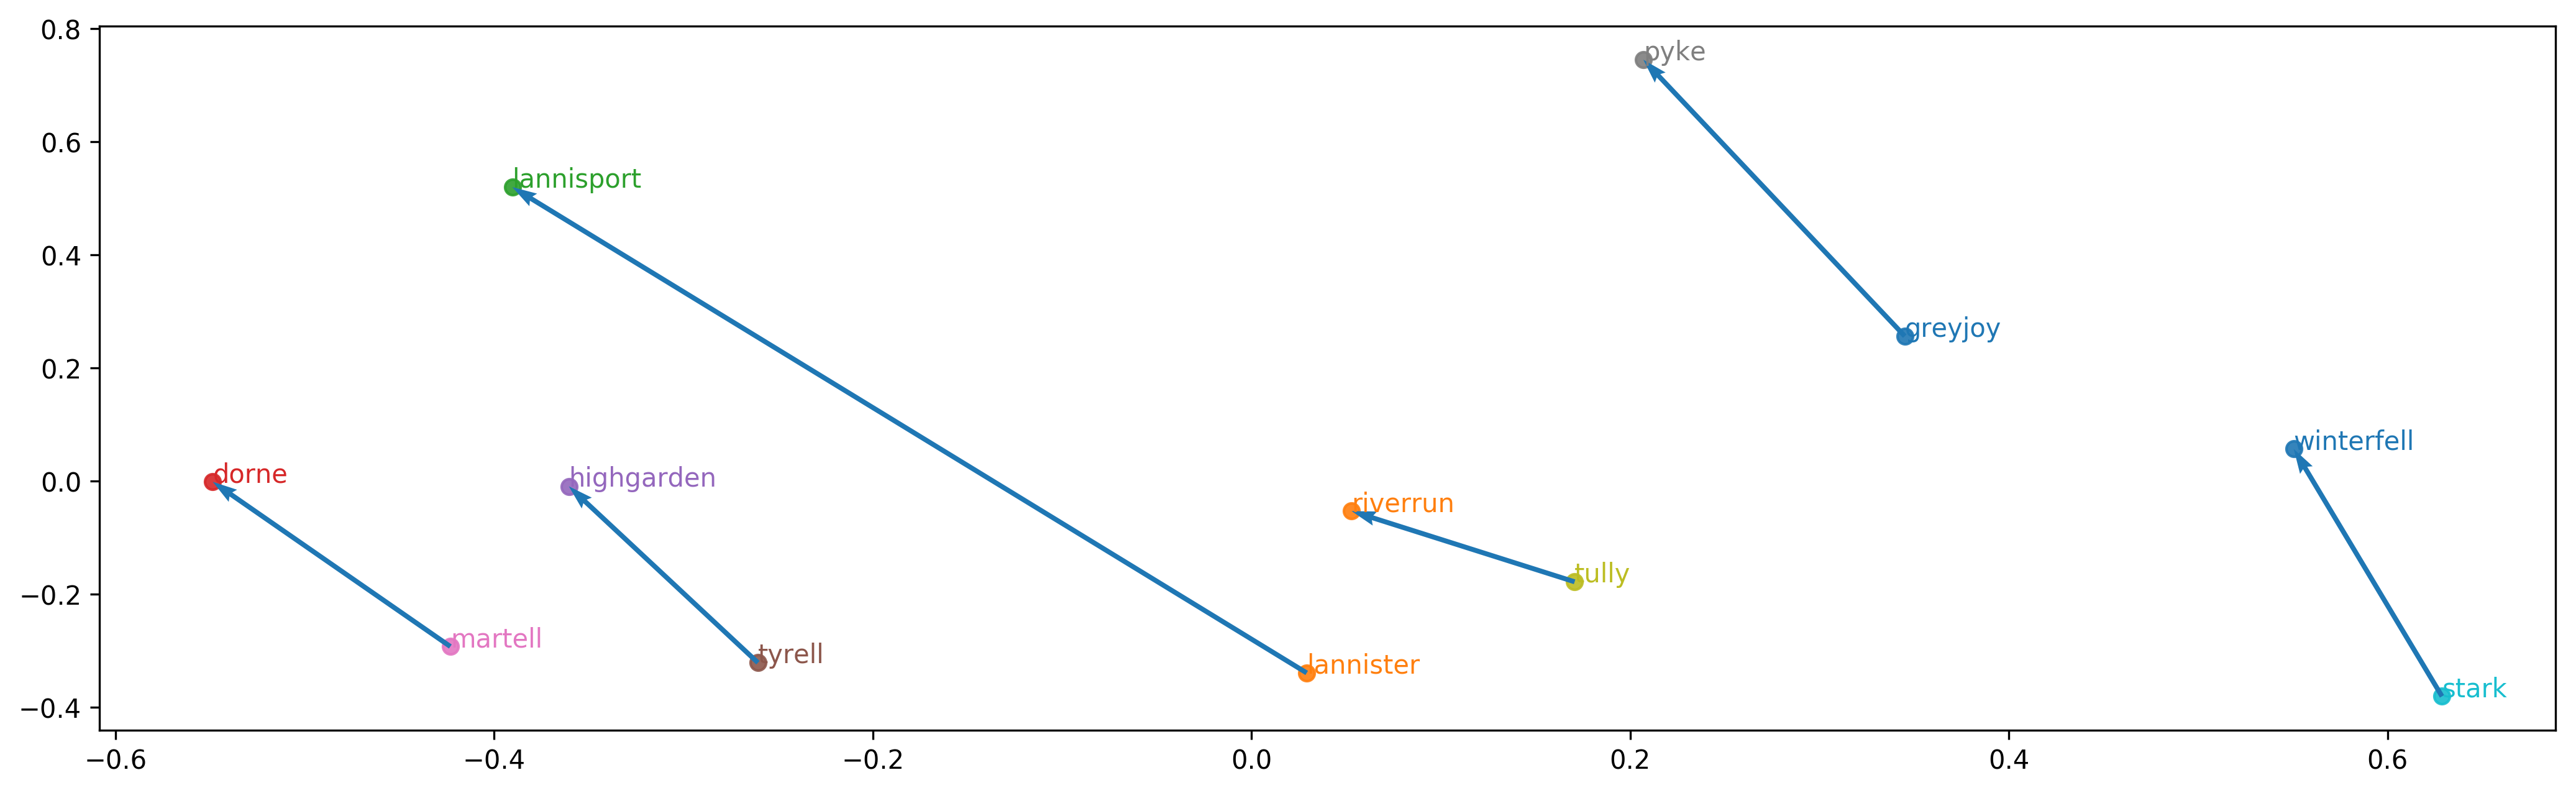

In [7]:
# house to seat
word_pairs = [
    ("stark", "winterfell"),
    ("tully", "riverrun"),
    ("greyjoy", "pyke"),
    ("martell", "dorne"),
    ("tyrell", "highgarden"),
    ("lannister", "lannisport"),
]
plot_word_pairs(df, word_pairs, method="PCA")

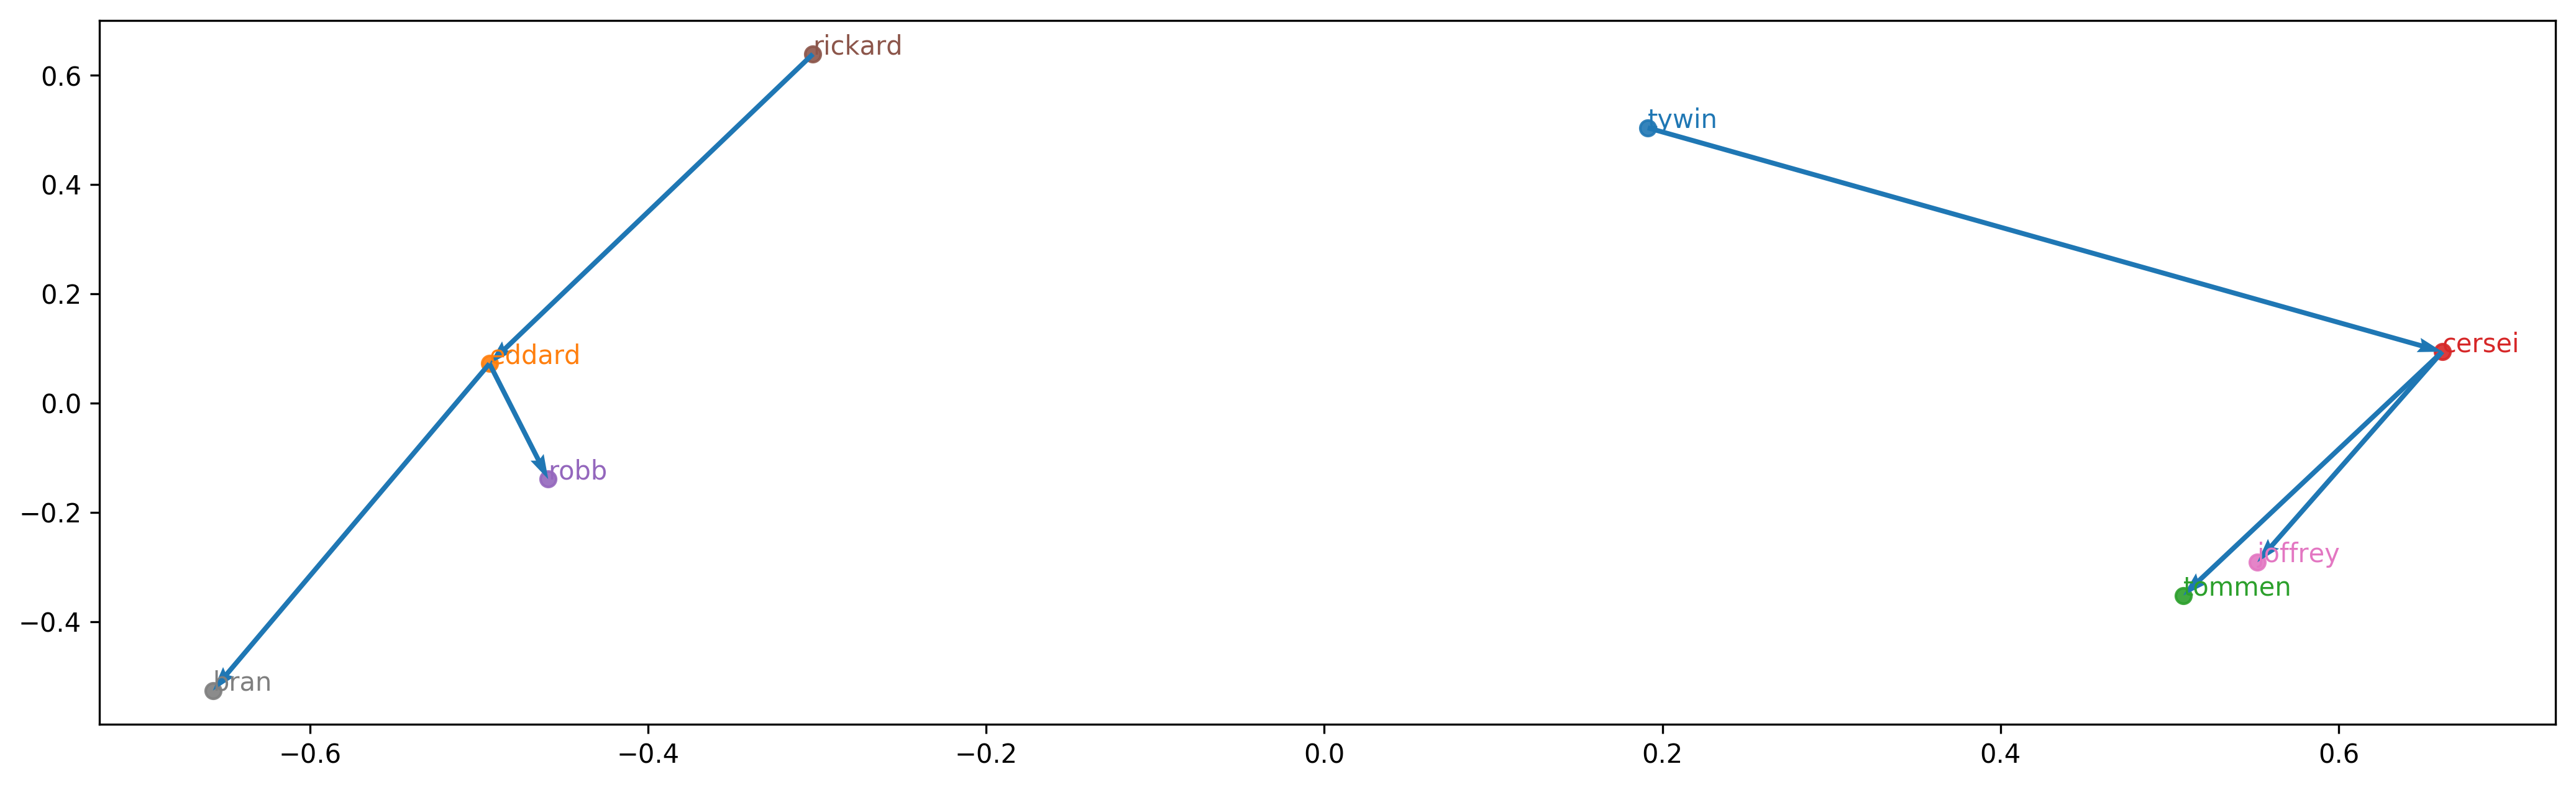

In [8]:
# ~family tree
word_pairs = [
    ("eddard", "robb"),
    ("eddard", "bran"),
    ("cersei", "tommen"),
    ("cersei", "joffrey"),
    ("tywin", "cersei"),
    ("rickard", "eddard"),
]
plot_word_pairs(df, word_pairs, method="PCA")

## Word2Viz-style plots

In [9]:
colors = plt.cm.tab20.colors

def word2viz_plot(df, words, x_op, y_op, labels=None):
    """Plot selected words on a 2-D plane
      Each word gets its coordinates x and y from
      its dot product with the vector differences x_op, and y_op
    """
    dfs = df.loc[words]
    x2, x1 = x_op.split(" - ")
    y2, y1 = y_op.split(" - ")
    x_label = "%s --------> %s" % (x1, x2)
    y_label = "%s --------> %s" % (y1, y2)
    
    word_labels = dfs.index if labels is None else labels

    dfs["x"] = dfs.iloc[:,:100].dot(df.loc[x2] - df.loc[x1])
    dfs["y"] = dfs.iloc[:,:100].dot(df.loc[y2] - df.loc[y1])

    fig = plt.figure(figsize=(12,6), dpi=300)
    ax = fig.add_subplot(1,1,1)

    for i in range(len(dfs)):
        x, y, text = dfs.iloc[i]["x"], dfs.iloc[i]["y"], word_labels[i]
        ax.scatter(x, y, alpha=0.9, c=colors[i%20])
        ax.text(x, y, text, alpha=0.9, color=colors[i%20])

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()

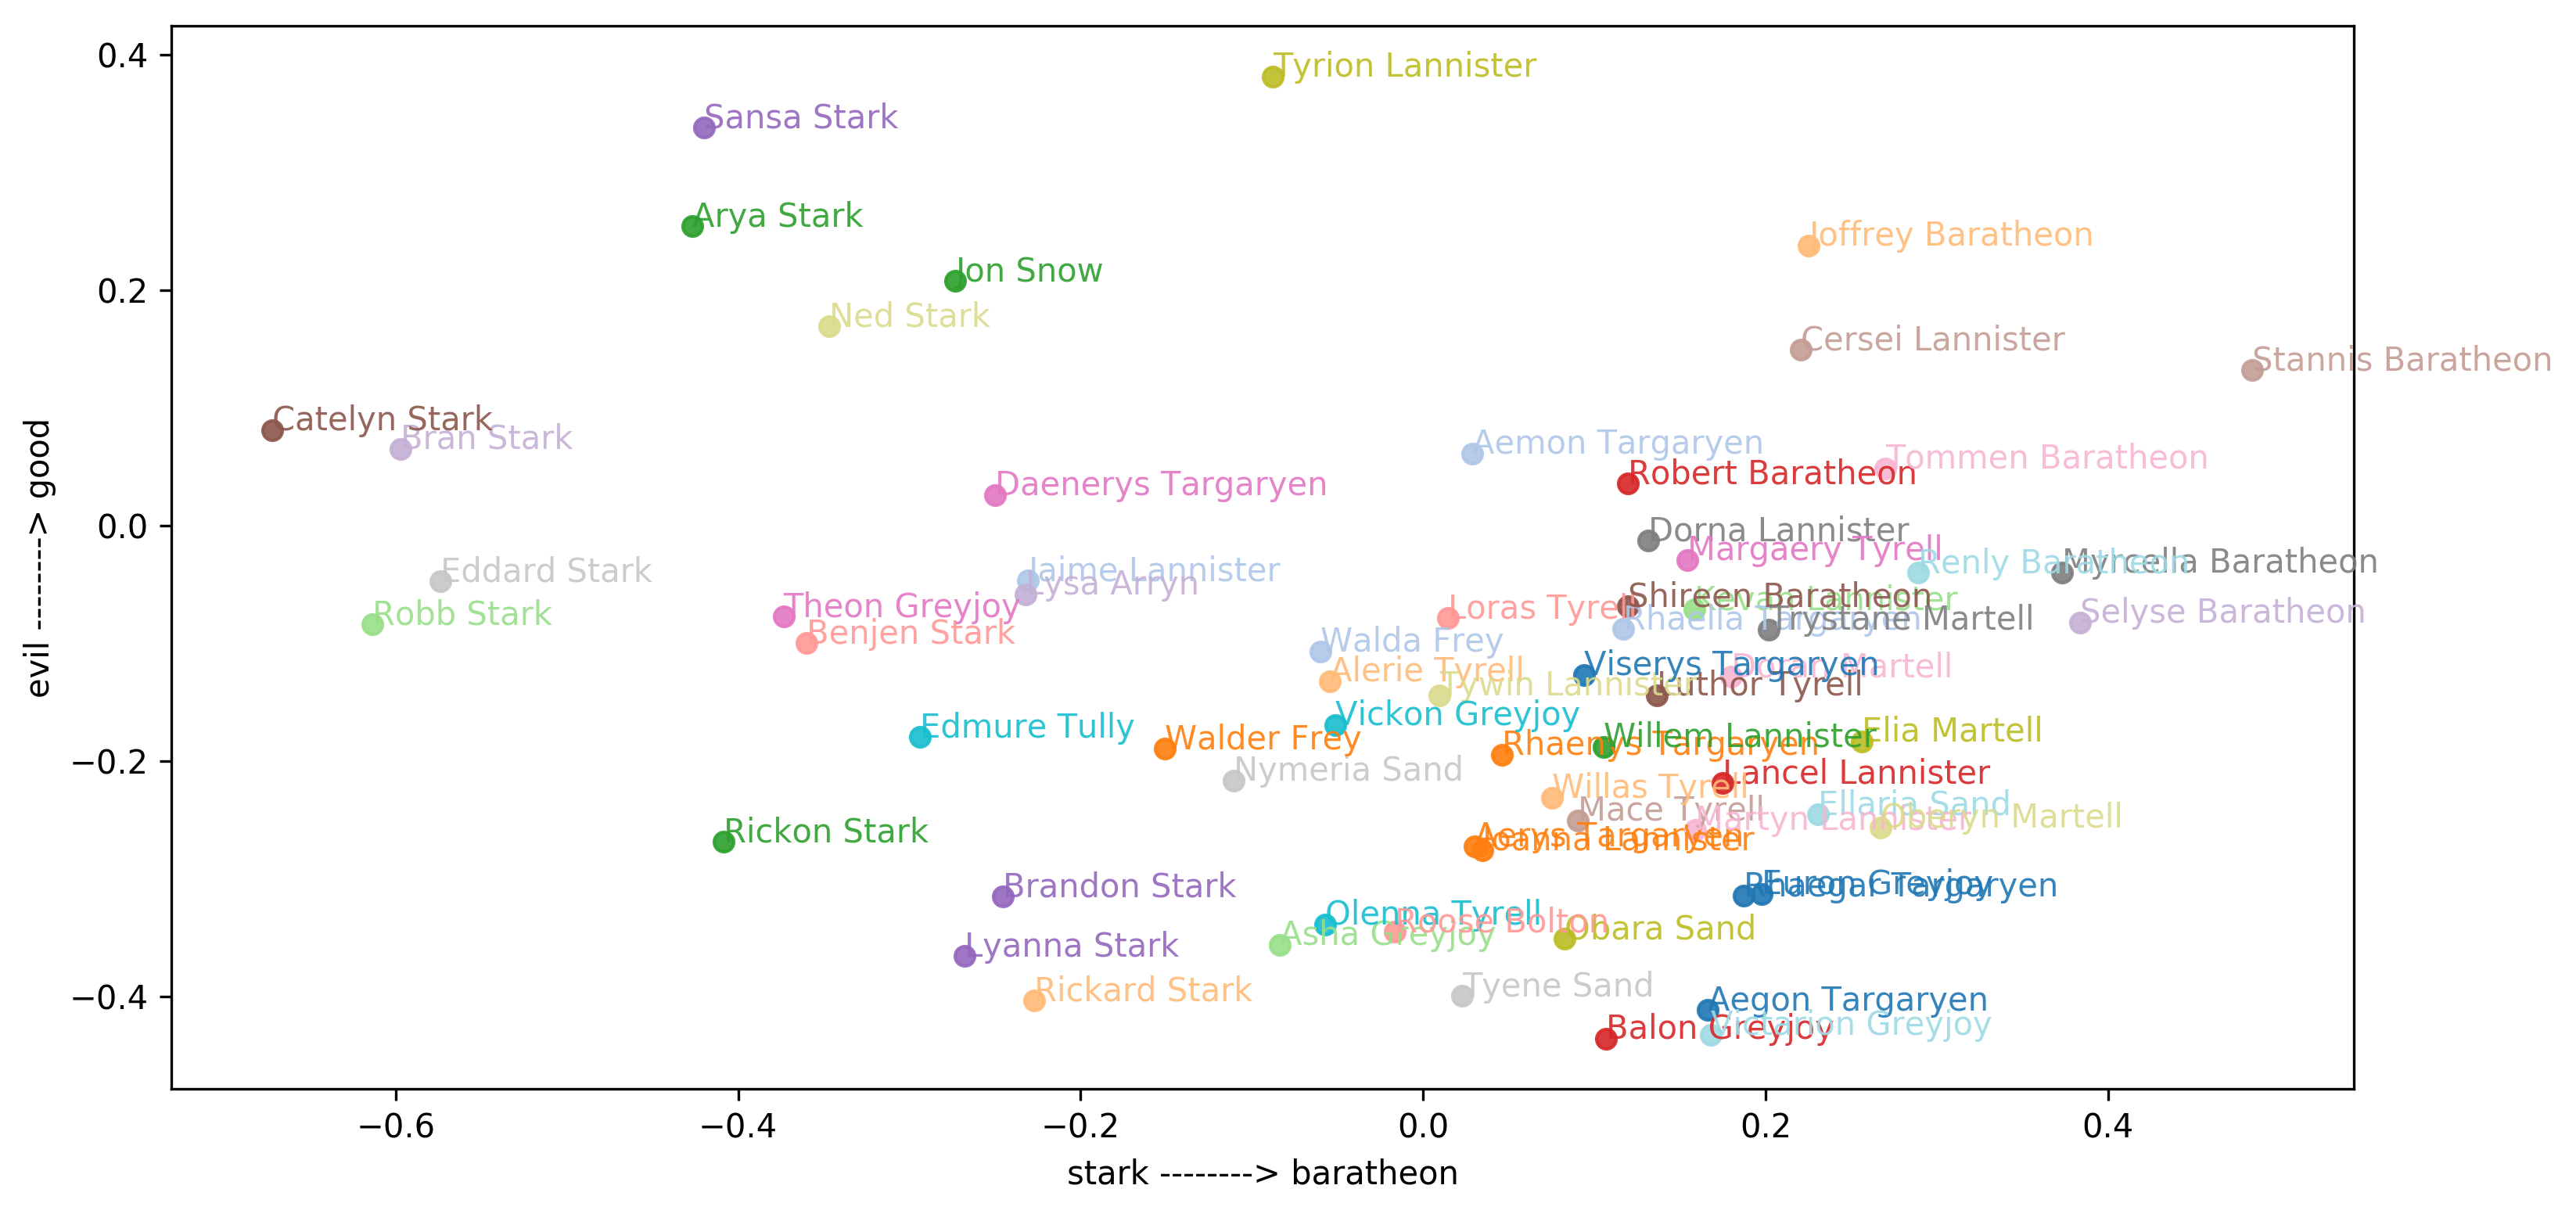

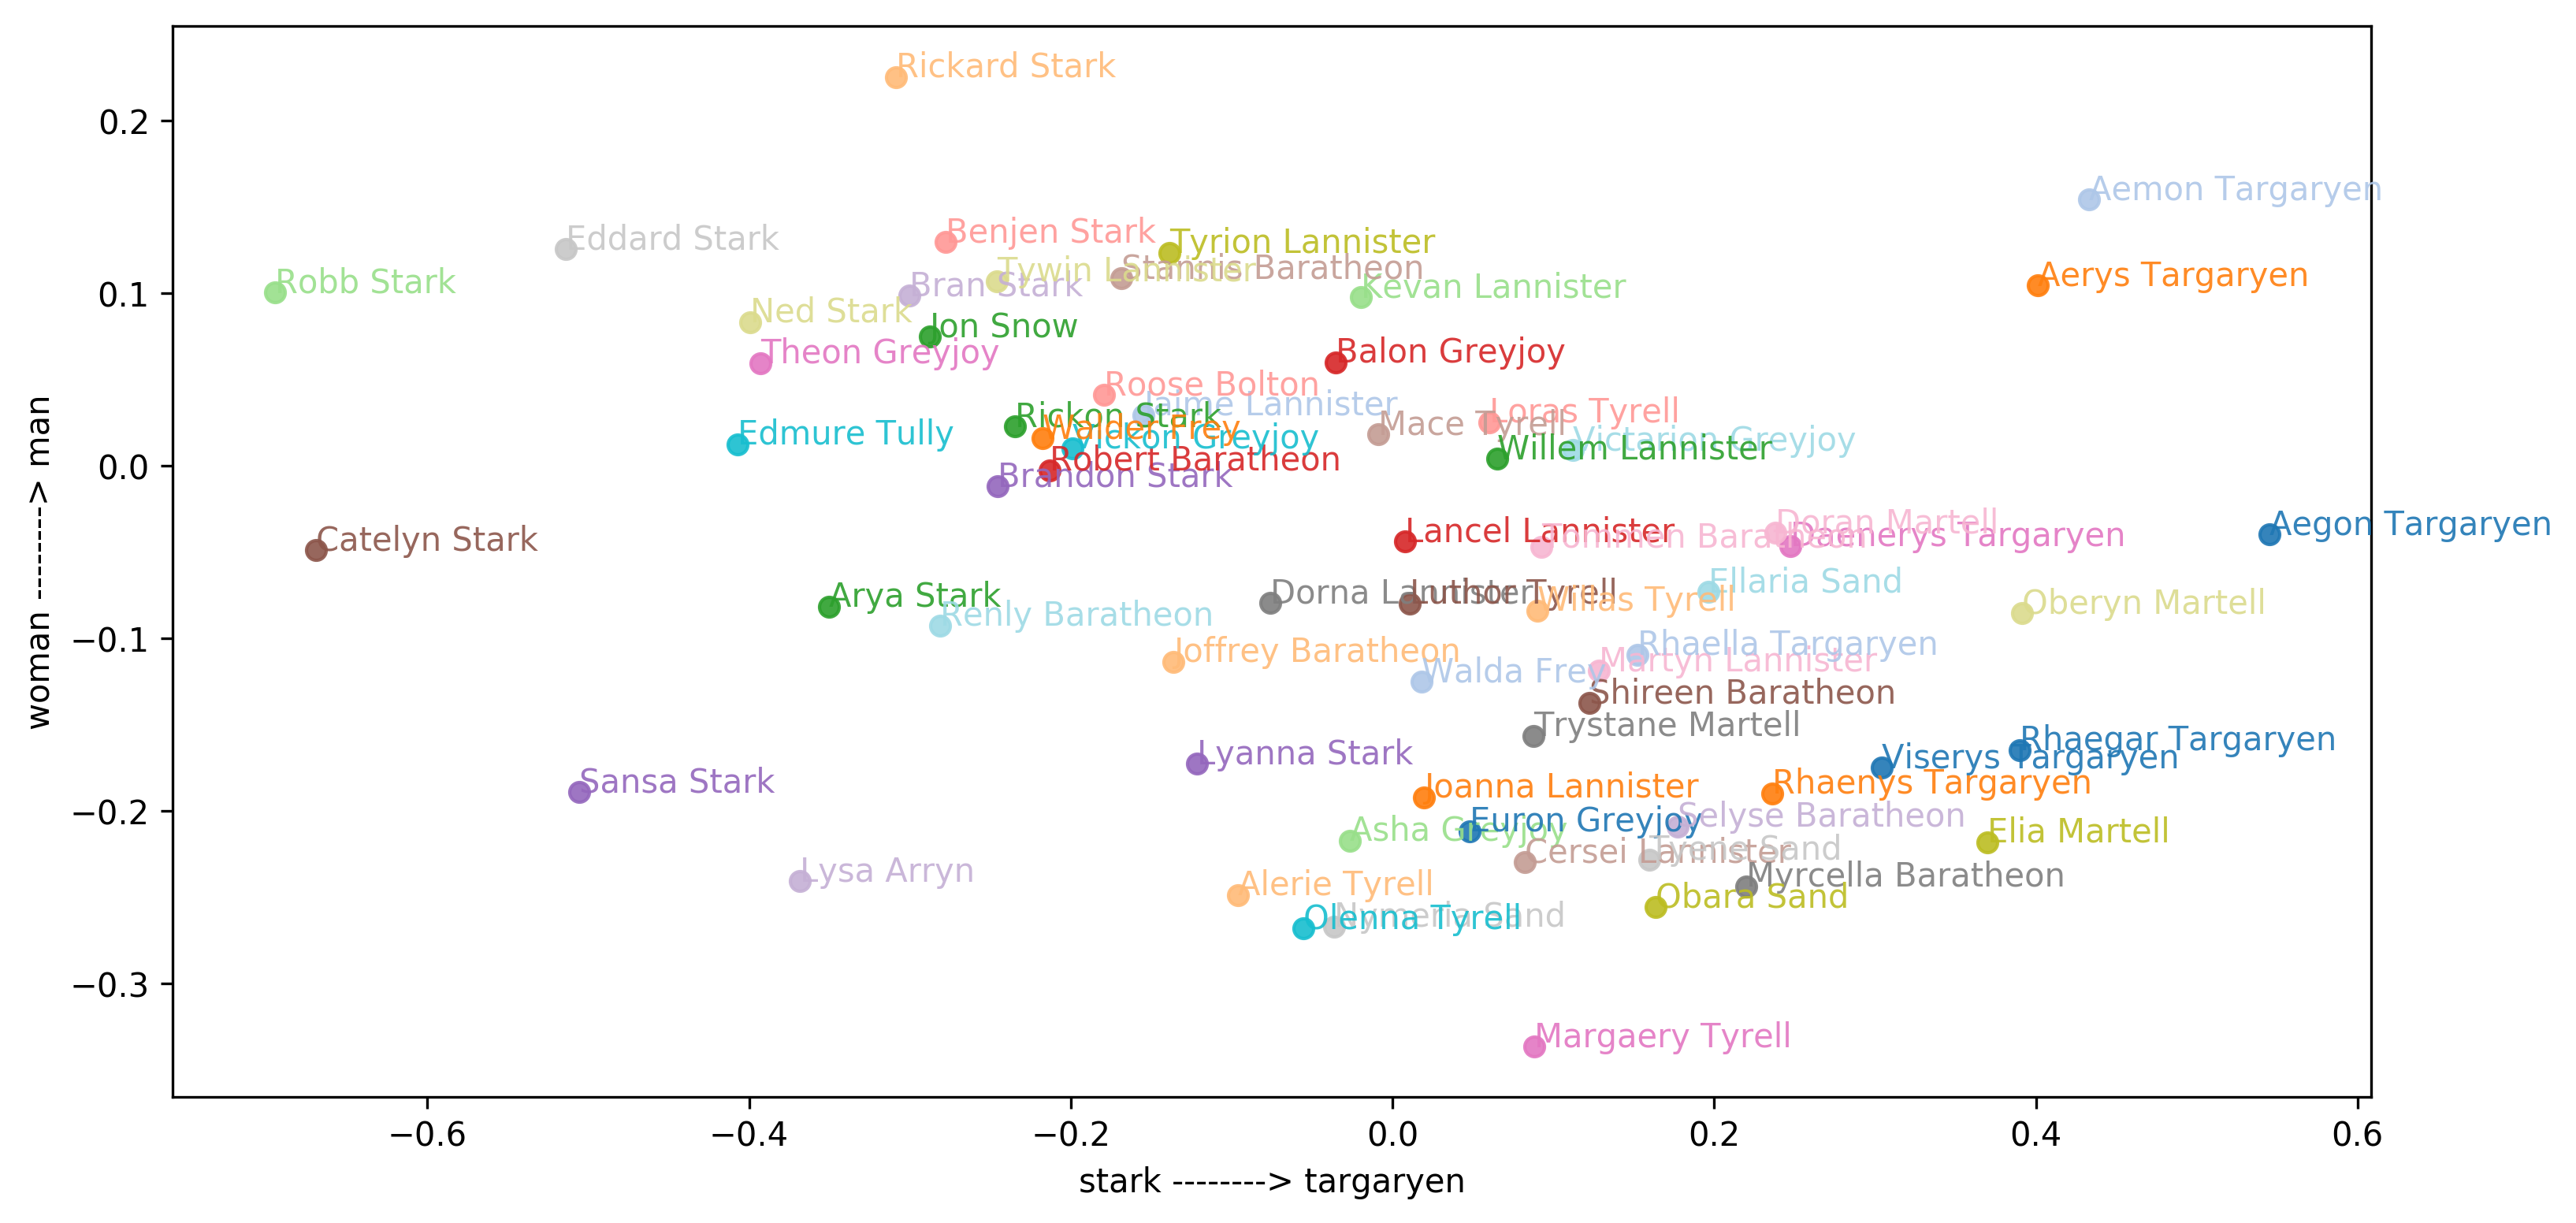

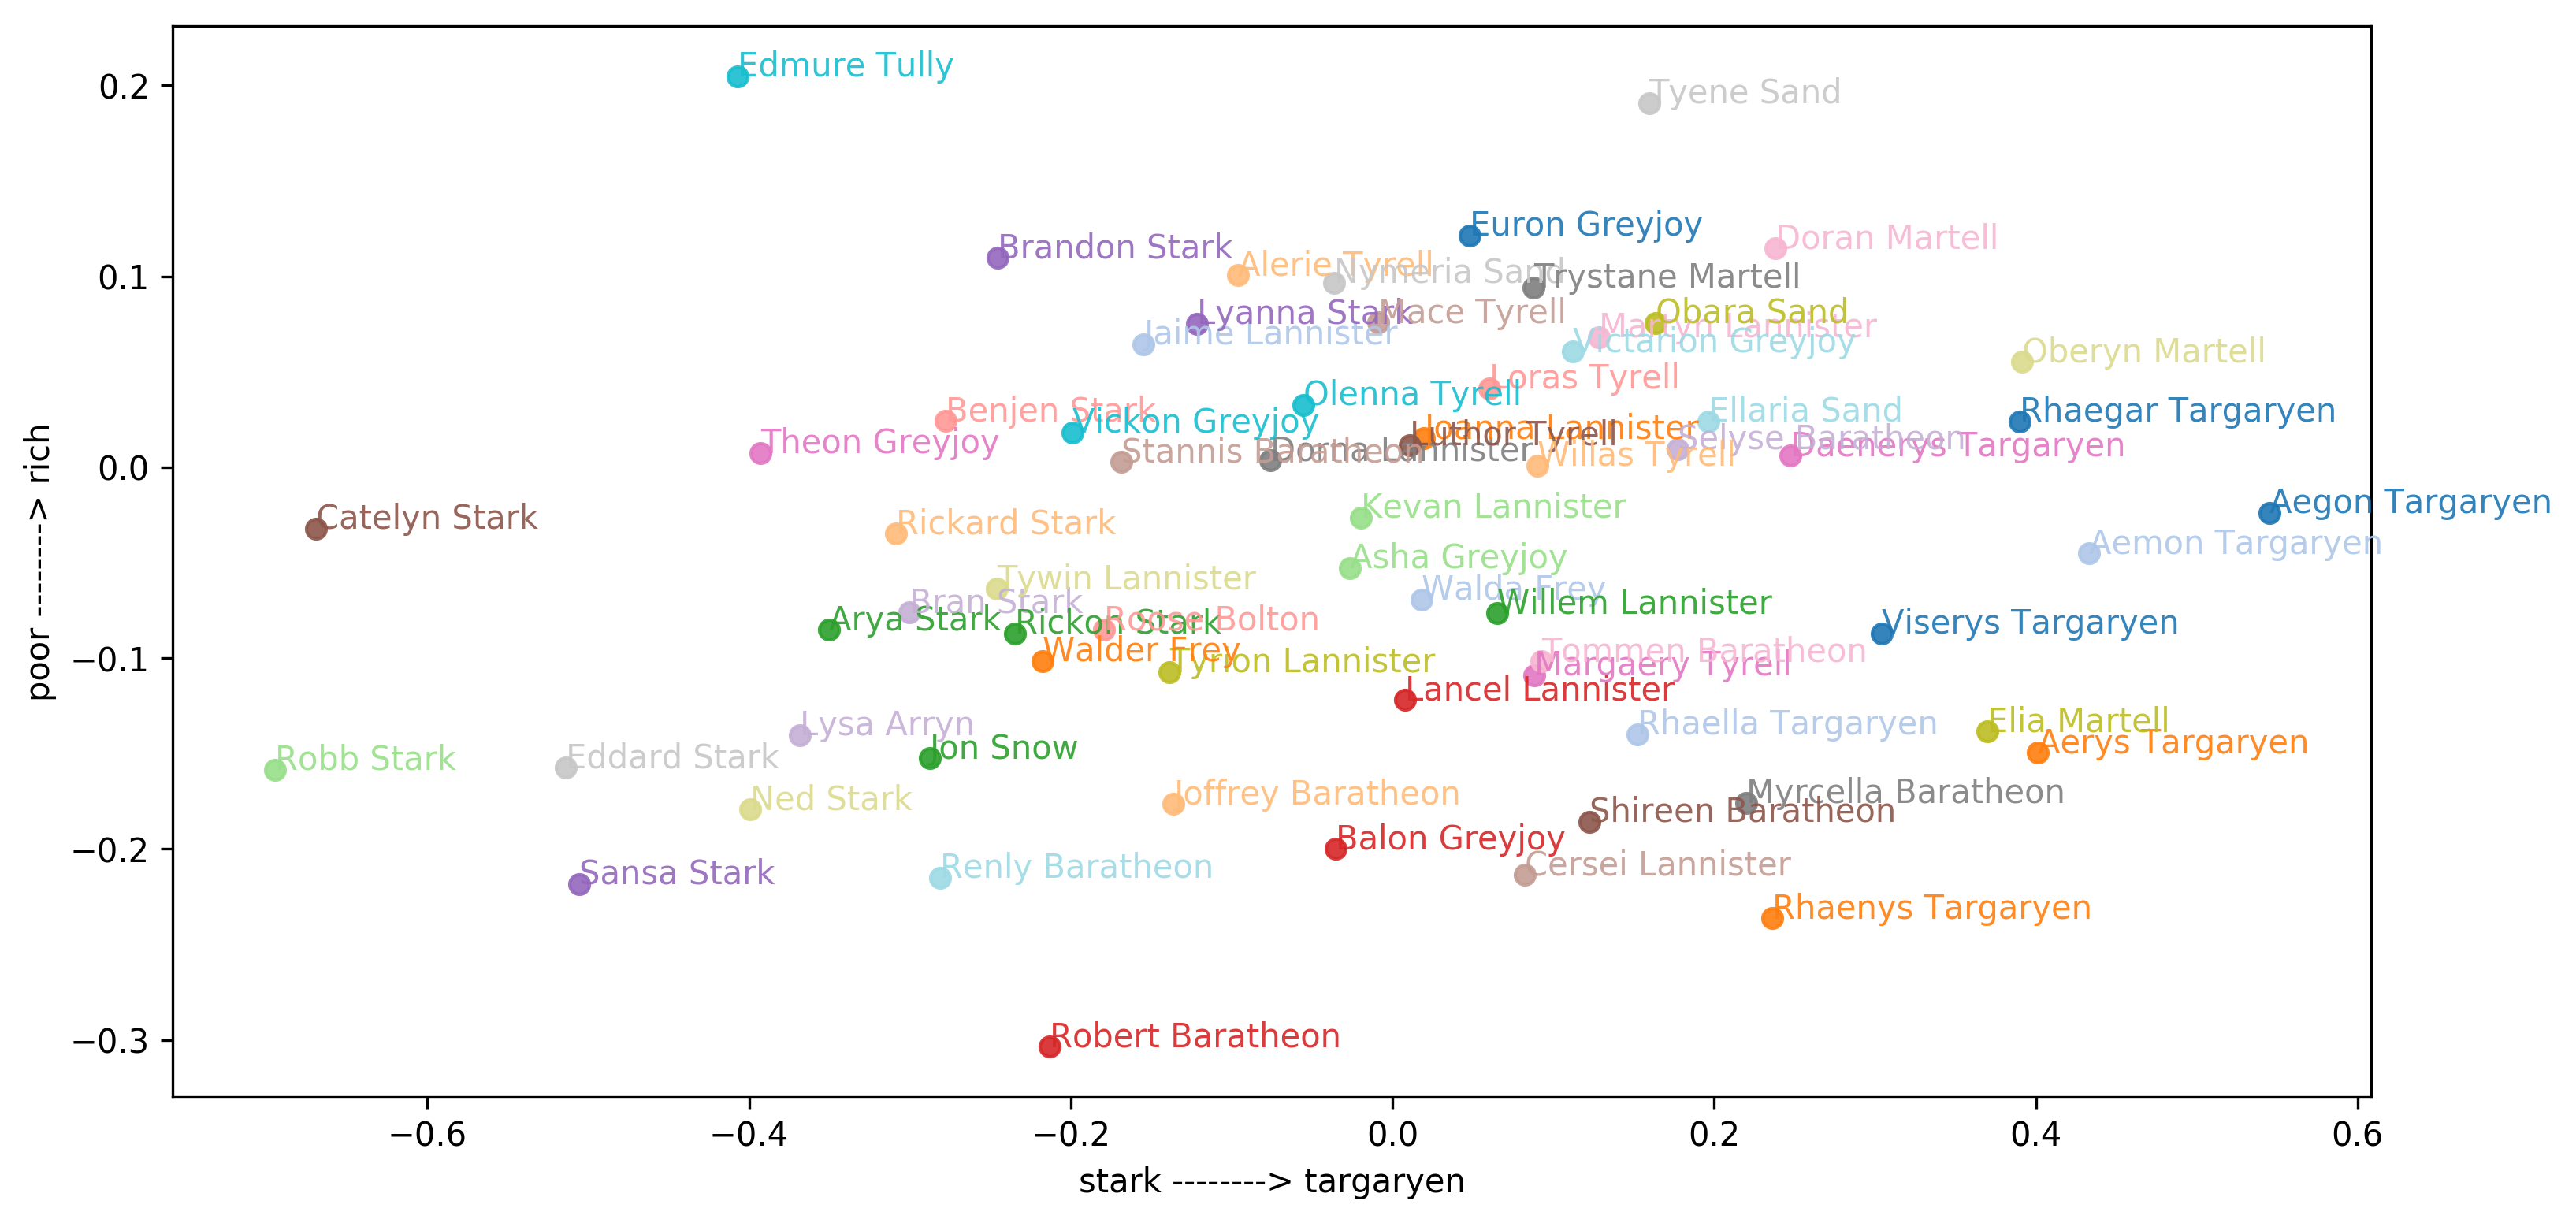

In [10]:
word2viz_plot(df, characters["first_name"], "baratheon - stark", "good - evil", labels=characters["full_name"])
word2viz_plot(df, characters["first_name"], "targaryen - stark", "man - woman", labels=characters["full_name"])
word2viz_plot(df, characters["first_name"], "targaryen - stark", "rich - poor", labels=characters["full_name"])